In [1]:
# Useful imports
import numpy as np
from matplotlib.pyplot import figure, show
from astropy.io import fits
from pathlib import Path
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
# path to data
path = "/net/virgo01/data/users/mpucovsky/OAProject/2025-05-05"
pathObj = Path(path)

In [3]:
# Creates table of flat frames, for inspection
print(f"{'Filename':30s} | {'Object':20s} | {'Image shape':10s} | {'Exposure time':15s} | {'Filter':10s}")
for f in pathObj.iterdir():
    hduList = fits.open(f)
    head = hduList[0].header
    data = hduList[0].data
    name = f.name
    if head['IMAGETYP'] == "FLAT":
        # accounts for possibility of missing metadata
        try:
            obj = head['OBJECT']
        except:
            obj = "OBJECT keyword N/A"

        try:
            expt = str(head['EXPTIME'])
        except:
            expt = "EXPTIME keyword N/A"

        try:
            filt = head['FILTER']
        except:
            filt = "FILTER keyword N/A"

        print(f"{name:30s} | {obj:20s} | {data.shape} | {expt:15s} | {filt:10s}")
    hduList.close()


Filename                       | Object               | Image shape | Exposure time   | Filter    
LDST_250505-0008_FlatR3.fit    | LDST_250505          | (1173, 1552) | 30.0            | R*        
LDST_250505-0001_FlatB3.fit    | LDST_250505          | (1173, 1552) | 1.0             | B*        
LDST_250505-0004_FlatG3.fit    | LDST_250505          | (1173, 1552) | 1.0             | G*        
LDST_250505-0003_FlatR3.fit    | LDST_250505          | (1173, 1552) | 1.0             | R*        
LDST_250505-0008_FlatG3.fit    | LDST_250505          | (1173, 1552) | 30.0            | G*        
LDST_250505-0004_FlatR3.fit    | LDST_250505          | (1173, 1552) | 1.0             | R*        
LDST_250505-0010_FlatB3.fit    | LDST_250505          | (1173, 1552) | 30.0            | B*        
LDST_250505-0006_FlatB3.fit    | LDST_250505          | (1173, 1552) | 30.0            | B*        
LDST_250505-0003_FlatG3.fit    | LDST_250505          | (1173, 1552) | 1.0             | G*        
L

Context - some flats have expt 30s, this is due to these being mislabeled starfields. (see the logsheet)

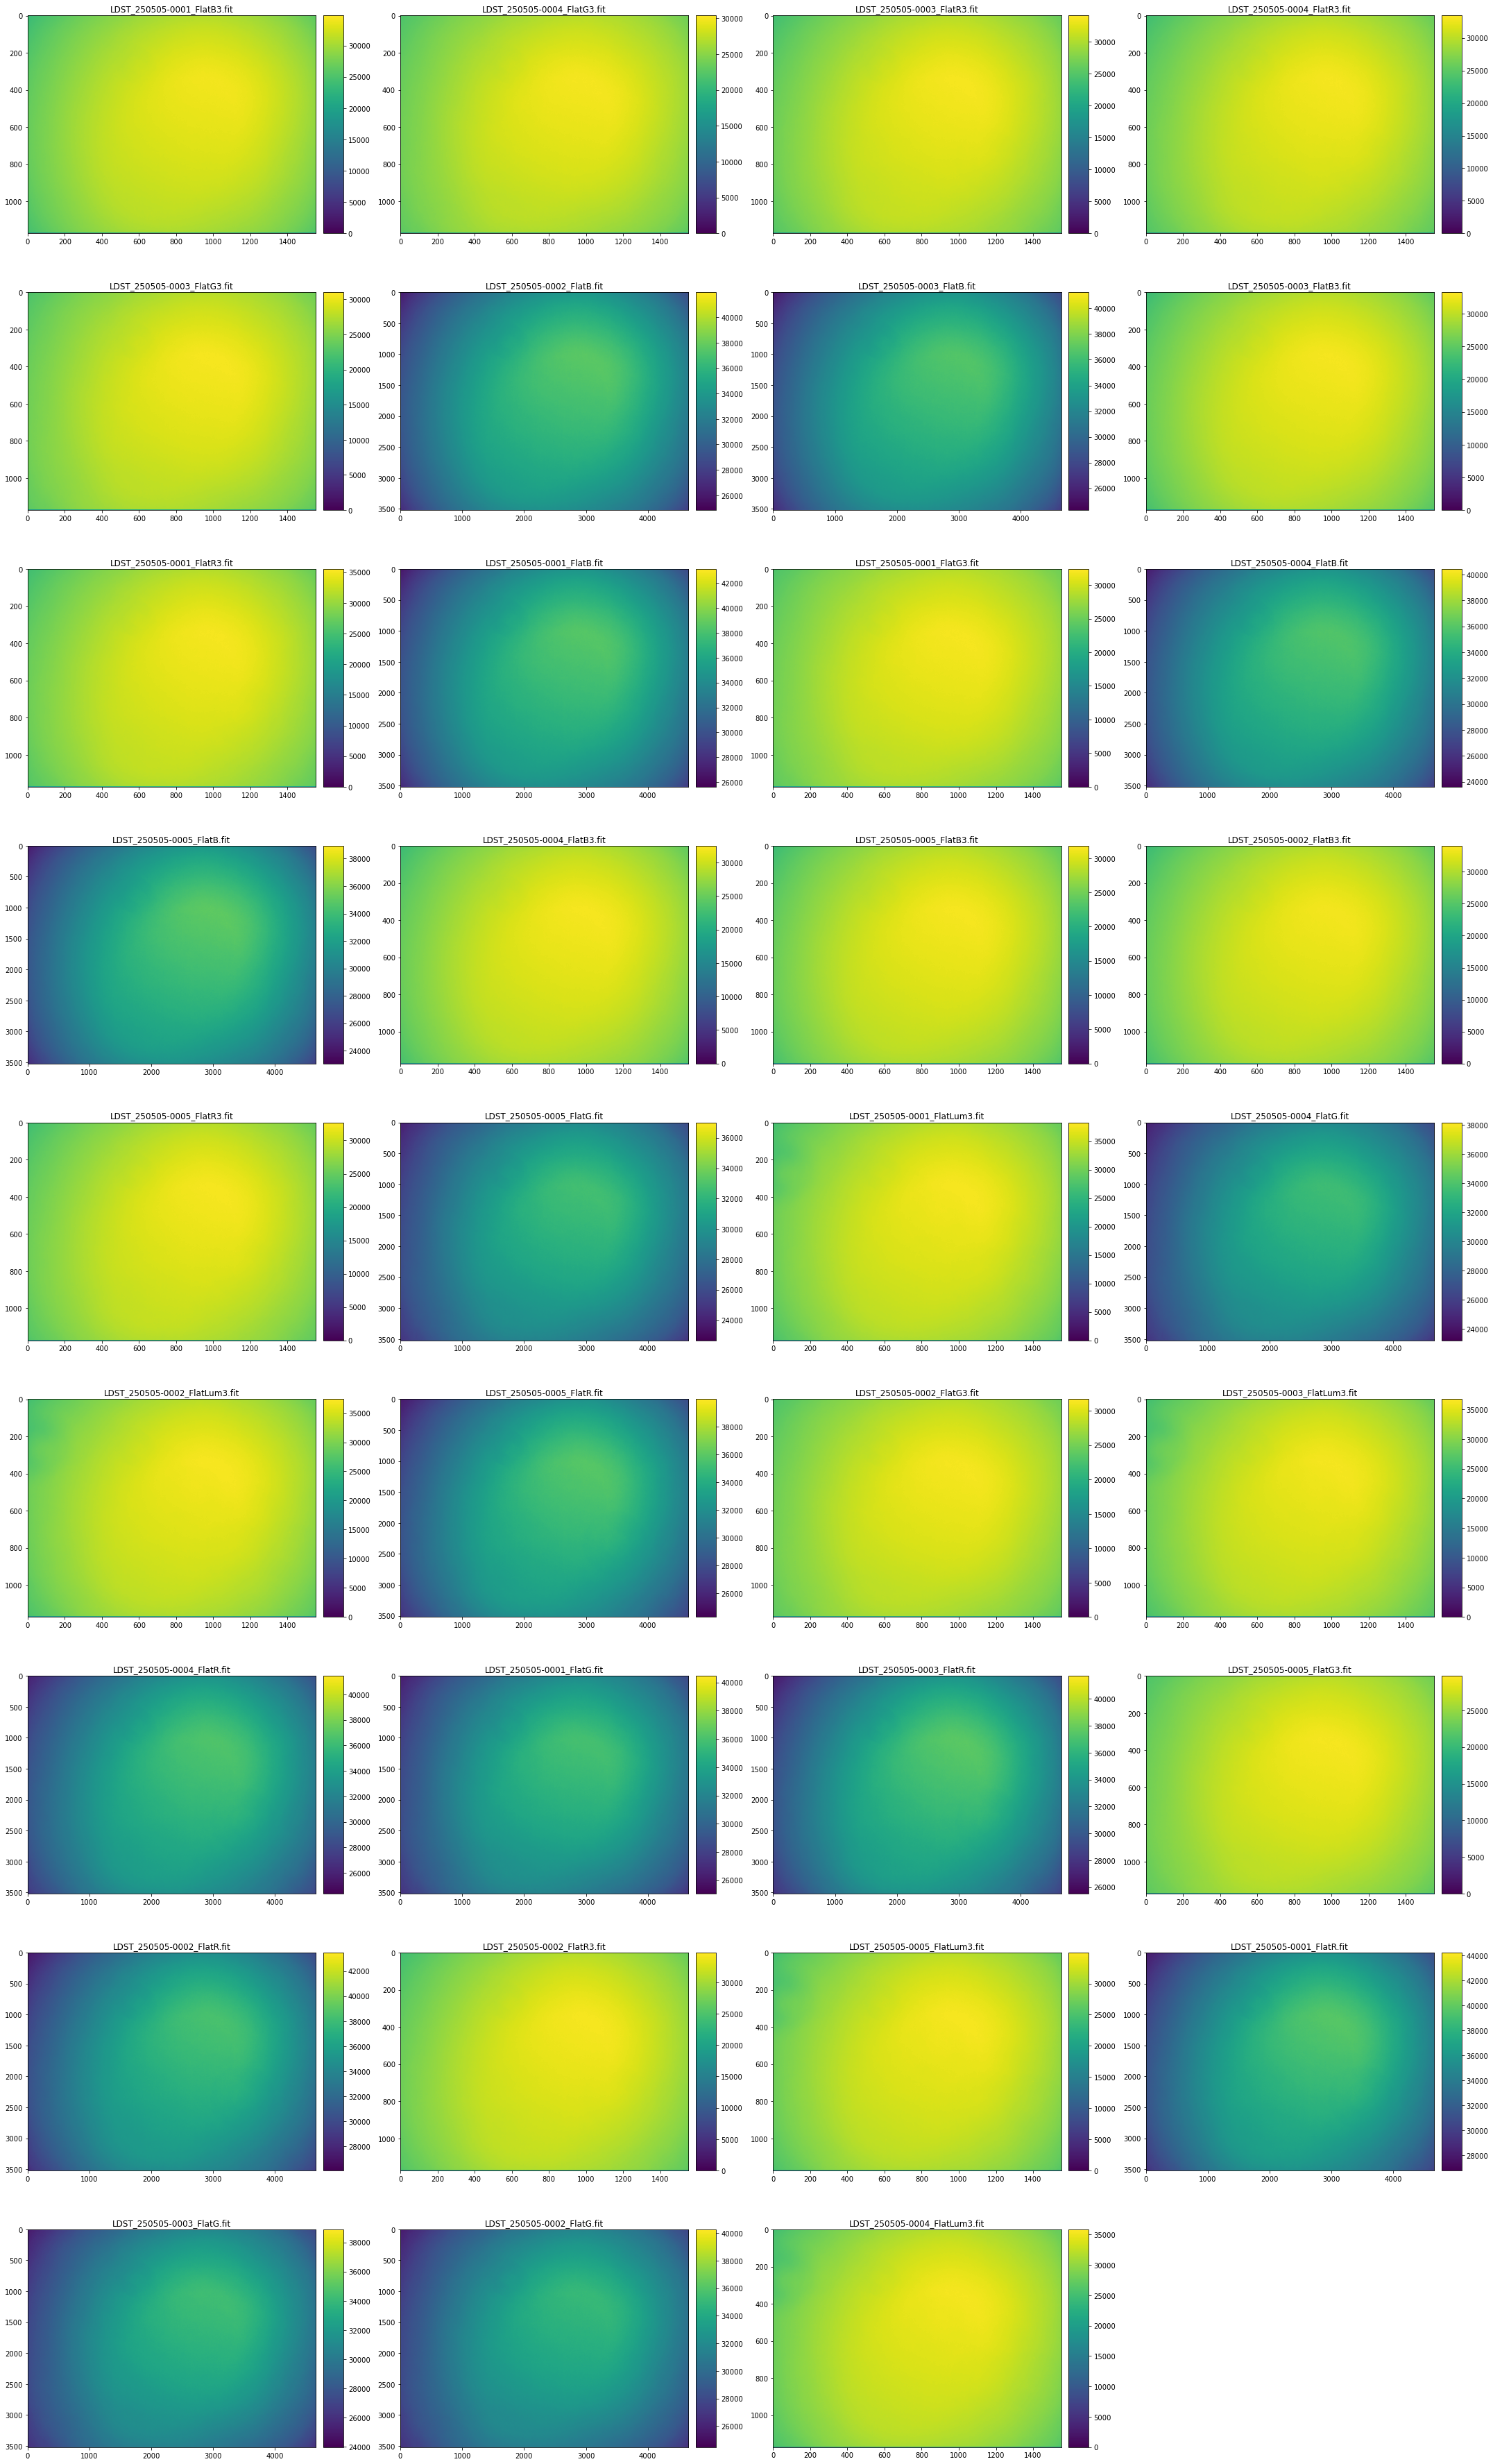

In [4]:
# Inspect each flat frame for saturated pixels, displays in a mosaic all flat frames,
# then visual inspection is used to find saturated/corrupted flat fields
fig= figure(figsize=(30,50))
i=1
for f in pathObj.iterdir():
    hduList = fits.open(f)
    head = hduList[0].header
    name = f.name
    if "Flat" in name and head['EXPTIME'] < 30.0:
        figAxes = fig.add_subplot(9,4,i)
        data = hduList[0].data
        image = figAxes.imshow(data, cmap="viridis")
        divider = make_axes_locatable(figAxes)
        colbar = divider.append_axes("right", size="7%", pad=0.15)
        fig.colorbar(image, cax=colbar)
        figAxes.set_title(name)
        i+=1
fig.tight_layout()

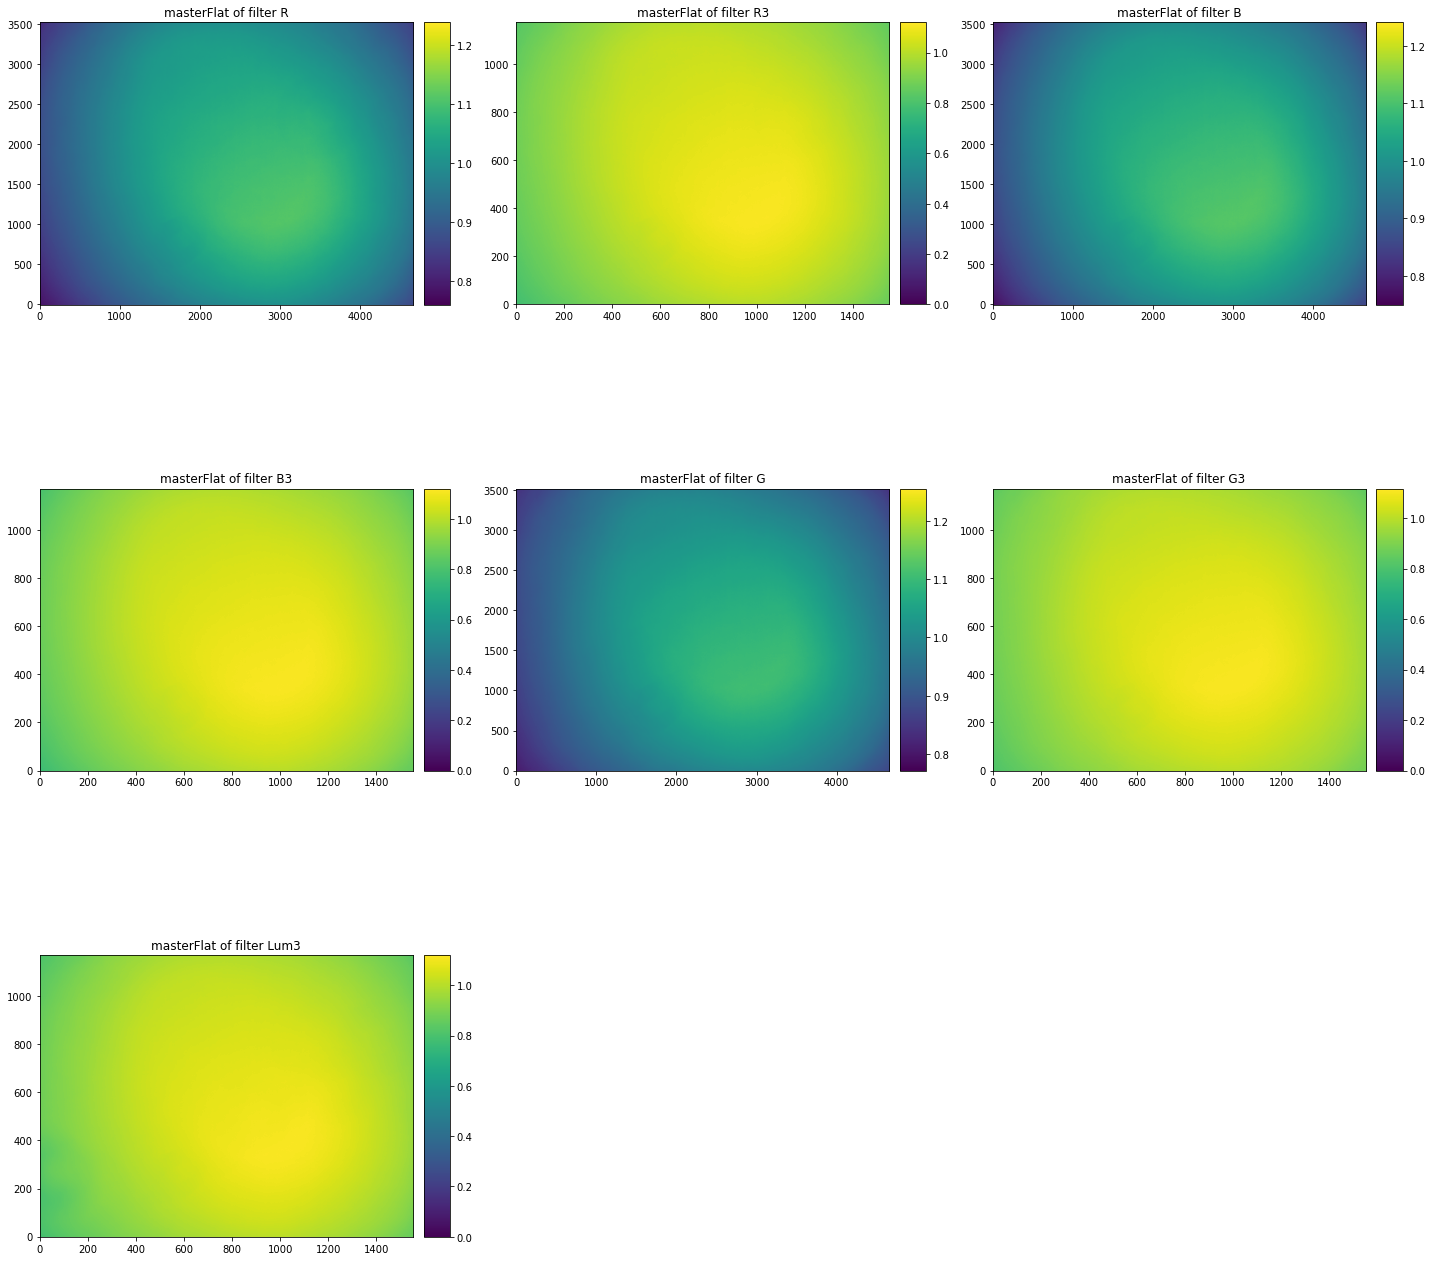

In [5]:
flatDesc = ["R", "R3", "B", "B3", "G", "G3", "Lum3"]
masterFlats = []

hduList = fits.open(path+"/L10_MBias.fit")
masterBias = hduList[0].data.astype(float)
hduList.close()

hduList = fits.open(path+"/L10_MBias3.fit")
masterBias3 = hduList[0].data.astype(float)
hduList.close()

# loops through each filter
for fil in flatDesc:
    flats = []
    # identifies flat frames
    for f in pathObj.iterdir():
        hduList = fits.open(f)
        head = hduList[0].header
        name = f.name
        if head["IMAGETYP"].upper() == "FLAT":
            if "3" in fil:
                if fil in name and head["EXPTIME"] < 30.0:
                    # normalises flat field
                    data = hduList[0].data.astype(float)
                    data -= masterBias3
                    data /= data.mean()
                    flats.append(data)
            else:
                if fil in name and flatDesc[flatDesc.index(fil) + 1] not in name and head["EXPTIME"] < 30.0:
                    # normalises flat field
                    data = hduList[0].data.astype(float)
                    data -= masterBias
                    data /= data.mean()
                    flats.append(data)

    # stacks all normalised flat fields for one filter, creates master flat for that filter
    datacube = np.stack(flats)
    masterFlat = np.median(datacube, axis=0)
    # masterFlat /= masterFlat.mean() # not sure if this line is necessary, prognum mentions having to do this, OA doesn't
    masterFlats.append(masterFlat)


# displays each master flat in a mosaic
fig = figure(figsize=(20,20))
for i in range(0,7):
    figAxes = fig.add_subplot(3,3,i+1)
    image = figAxes.imshow(masterFlats[i], cmap="viridis", origin="lower")
    divider = make_axes_locatable(figAxes)
    colbar = divider.append_axes("right", size="7%", pad=0.15)
    fig.colorbar(image, cax=colbar)
    figAxes.set_title(f"masterFlat of filter {flatDesc[i]}")
    
fig.tight_layout()
show()

In [6]:
for i in range(0,7):
    header = head
    if i != 6:
        header["FILTER"] = flatDesc[i][:1]+"*"
    else:
        header["FILTER"] = flatDesc[i][:3]
    primary = fits.PrimaryHDU(masterFlats[i], header)
    hdu = fits.HDUList([primary])
    pathW = path+"/L10_MFlat"+flatDesc[i]+".fit"
    hdu.writeto(pathW, overwrite=True)